# Baseline for Doppler Effect-Based Channel Charting: CIRA (geodesic)

This notebook is based on our ["Dissimilarity Metric-Based Channel Charting" tutorial](https://dichasus.inue.uni-stuttgart.de/tutorials/tutorial/dissimilarity-metric-channelcharting/). Read the tutorial for a better understanding of what is going on here.

"CIRA" (Channel Impulse Response Amplitude) is what we call the dissimilarity metric introduced in "[Indoor Localization With Robust Global Channel Charting: A Time-Distance-Based Approach](https://arxiv.org/abs/2210.06294)" by M. Stahlke, G. Yammine, T. Feigl, B. M. Eskofier and C. Mutschler, see Eq. (13).

To function properly, this metric requires "time-aligned CIRs" (in their original paper, the authors achieve this by two-way ranging and padding the CIRs with their respective time of flights). However, the premise of our work on Doppler effect-based CC is that our technique works even if we do not have time synchronization across the receiver antennas.

Thus, for a fair comparison with our technique, which does not get time-synchronized CIRs, we remove the time synchronization as part of the `csi_time_domain` function while loading the dataset.
Instead of having time-aligned CIRs, reference to a common clock source (over-the-air synchronization signal, in the case of DICHASUS), we just time-align the CIRs to normalize the mean delay to zero.

In [1]:
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.manifold import trustworthiness
from scipy.sparse.csgraph import dijkstra
from scipy.spatial import distance_matrix
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import multiprocessing as mp
from tqdm.auto import tqdm
import tensorflow as tf
import numpy as np
import random
import queue
import json
        

# Just one antenna by array...
ASSIGNMENTS = [
    [16],
    [22],
    [1],
    [9]
]

ANTENNACOUNT = 32

def load_calibrate_timedomain(path, offset_path):
    offsets = None
    with open(offset_path, "r") as offsetfile:
        offsets = json.load(offsetfile)
    
    def record_parse_function(proto):
        record = tf.io.parse_single_example(
            proto,
            {
                "csi": tf.io.FixedLenFeature([], tf.string, default_value=""),
                "pos-tachy": tf.io.FixedLenFeature([], tf.string, default_value=""),
                "time": tf.io.FixedLenFeature([], tf.float32, default_value=0),
            },
        )

        csi = tf.ensure_shape(tf.io.parse_tensor(record["csi"], out_type=tf.float32), (ANTENNACOUNT, 1024, 2))
        csi = tf.complex(csi[:, :, 0], csi[:, :, 1])
        csi = tf.signal.fftshift(csi, axes=1)

        position = tf.ensure_shape(tf.io.parse_tensor(record["pos-tachy"], out_type=tf.float64), (3))
        time = tf.ensure_shape(record["time"], ())

        return csi, position[:2], time

    def apply_calibration(csi, pos, time):
        sto_offset = tf.tensordot(tf.constant(offsets["sto"]), 2 * np.pi * tf.range(tf.shape(csi)[1], dtype = np.float32) / tf.cast(tf.shape(csi)[1], np.float32), axes = 0)
        cpo_offset = tf.tensordot(tf.constant(offsets["cpo"]), tf.ones(tf.shape(csi)[1], dtype = np.float32), axes = 0)
        csi = tf.multiply(csi, tf.exp(tf.complex(0.0, sto_offset + cpo_offset)))

        return csi, pos, time

    def csi_time_domain(csi, pos, time):
        # Here, we remove the time synchronization.
        # We do this by estimating the mean STO *per antenna*, and compensating for STO on a per-antenna basis.
        sto_increment_estimate = tf.cast(tf.math.angle(tf.math.reduce_sum(csi[...,1:] * tf.math.conj(csi[...,:-1]), axis = -1)), tf.complex64)
        csi_freq_domain_nosto = csi * tf.exp(-1.0j * sto_increment_estimate[:, tf.newaxis] * tf.cast(tf.range(csi.shape[-1]), tf.complex64)[tf.newaxis,:])

        # If you want to see how much better CIRA performs if we keep time synchronization, comment out the two lines above and
        # uncomment the two lines below.
        #sto_increment_estimate = tf.cast(tf.math.angle(tf.math.reduce_sum(csi[...,1:] * tf.math.conj(csi[...,:-1]))), tf.complex64)
        #csi_freq_domain_nosto = csi * tf.exp(-1.0j * sto_increment_estimate * tf.cast(tf.range(csi.shape[-1]), tf.complex64))[tf.newaxis,:]
        
        csi_tdomain = tf.signal.fftshift(tf.signal.ifft(tf.signal.fftshift(csi_freq_domain_nosto, axes=1)), axes=1)

        # Randomize per-antenna, per-datapoint starting phase
        csi_tdomain = tf.exp(tf.complex(0.0, tf.random.uniform([csi_tdomain.shape[0]], -np.pi, np.pi)))[:, tf.newaxis] * csi_tdomain

        return csi_tdomain, pos, time

    def cut_out_taps(tap_start, tap_stop):
        def cut_out_taps_func(csi, pos, time):
            return csi[:,tap_start:tap_stop], pos, time

        return cut_out_taps_func

    def order_by_antenna_assignments(csi, pos, time):
        csi = tf.stack([tf.gather(csi, antenna_inidces) for antenna_inidces in ASSIGNMENTS])
        return csi, pos, time
    
    dataset = tf.data.TFRecordDataset(path)
    
    dataset = dataset.map(record_parse_function, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.map(apply_calibration, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.map(csi_time_domain, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.map(cut_out_taps(507, 520), num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.map(order_by_antenna_assignments, num_parallel_calls = tf.data.AUTOTUNE)

    return dataset

inputpaths = [
    {
        "tfrecords" : "dataset/dichasus-cf02.tfrecords",
        "offsets" : "dataset/reftx-offsets-dichasus-cf02.json"
    },
    {
        "tfrecords" : "dataset/dichasus-cf03.tfrecords",
        "offsets" : "dataset/reftx-offsets-dichasus-cf03.json"
    },
    {
        "tfrecords" : "dataset/dichasus-cf04.tfrecords",
        "offsets" : "dataset/reftx-offsets-dichasus-cf04.json"
    }
]

full_dataset = load_calibrate_timedomain(inputpaths[0]["tfrecords"], inputpaths[0]["offsets"])

for path in inputpaths[1:]:
    full_dataset = full_dataset.concatenate(load_calibrate_timedomain(path["tfrecords"], path["offsets"]))

2024-04-14 17:12:21.707982: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 17:12:22.458937: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-14 17:12:23.331621: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-14 17:12:23.355308: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [2]:
# Decimate dataset: Use only every 4th datapoint (to reduce number of points)
training_set = full_dataset.enumerate().filter(lambda idx, value : (idx % 4 == 0))
training_set = training_set.map(lambda idx, value : value)

2024-04-14 17:12:24.251293: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


# From TensorFlow to NumPy

In [3]:
groundtruth_positions = []
csi_time_domain = []
timestamps = []

for csi, pos, time in training_set.batch(1000):
    csi_time_domain.append(csi.numpy())
    groundtruth_positions.append(pos.numpy())
    timestamps.append(time.numpy())

csi_time_domain = np.concatenate(csi_time_domain)
groundtruth_positions = np.concatenate(groundtruth_positions)
timestamps = np.concatenate(timestamps)

# Visualizing the Dataset

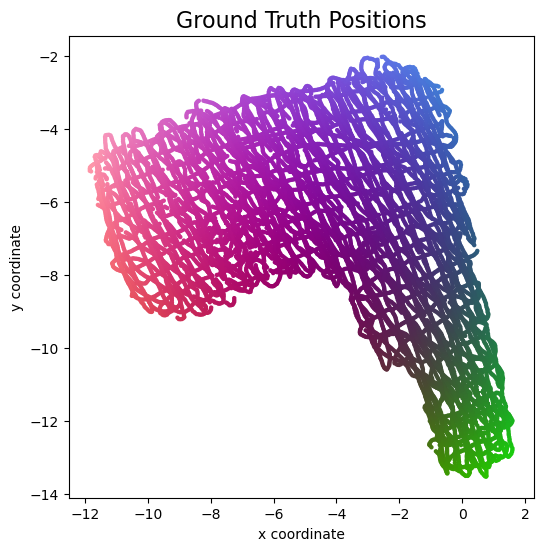

In [4]:
def plot_colorized(positions, groundtruth_positions, title = None, show = True, alpha = 1.0):
    # Generate RGB colors for datapoints
    center_point = np.zeros(2, dtype = np.float32)
    center_point[0] = 0.5 * (np.min(groundtruth_positions[:, 0], axis = 0) + np.max(groundtruth_positions[:, 0], axis = 0))
    center_point[1] = 0.5 * (np.min(groundtruth_positions[:, 1], axis = 0) + np.max(groundtruth_positions[:, 1], axis = 0))
    NormalizeData = lambda in_data : (in_data - np.min(in_data)) / (np.max(in_data) - np.min(in_data))
    rgb_values = np.zeros((groundtruth_positions.shape[0], 3))
    rgb_values[:, 0] = 1 - 0.9 * NormalizeData(groundtruth_positions[:, 0])
    rgb_values[:, 1] = 0.8 * NormalizeData(np.square(np.linalg.norm(groundtruth_positions - center_point, axis=1)))
    rgb_values[:, 2] = 0.9 * NormalizeData(groundtruth_positions[:, 1])

    # Plot datapoints
    plt.figure(figsize=(6, 6))
    if title is not None:
        plt.title(title, fontsize=16)
    plt.scatter(positions[:, 0], positions[:, 1], c = rgb_values, alpha = alpha, s = 10, linewidths = 0)
    plt.xlabel("x coordinate")
    plt.ylabel("y coordinate")
    if show:
        plt.show()

plot_colorized(groundtruth_positions, groundtruth_positions, title="Ground Truth Positions")

# Dissimilarity Metrics and Dissimilarity Matrix Computation

### Step 1: ADP-based dissimilarity matrix

In [5]:
@tf.function
def compute_cira_dissimilarity_matrix(csi_array):
    output = tf.TensorArray(tf.float32, size = csi_array.shape[0])

    for i in tf.range(csi_array.shape[0]):
        d = tf.concat([tf.zeros(i), tf.math.reduce_sum(tf.math.abs(tf.math.abs(csi_array[i:]) - tf.math.abs(csi_array[i])), axis = (1, 2, 3))], 0)

        output = output.write(i, d)

    dissim_upper_tri = output.stack()
    return dissim_upper_tri + tf.transpose(dissim_upper_tri)

cira_dissimilarity_matrix = compute_cira_dissimilarity_matrix(csi_time_domain).numpy() 

2024-04-14 17:12:43.995133: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1739056804 exceeds 10% of free system memory.


### Step 2: Geodesic Dissimilarity Matrix

In [6]:
n_neighbors = 20

nbrs_alg = NearestNeighbors(n_neighbors = n_neighbors, metric="precomputed", n_jobs = -1)
nbrs = nbrs_alg.fit(cira_dissimilarity_matrix)
nbg = kneighbors_graph(nbrs, n_neighbors, metric = "precomputed", mode="distance")

In [7]:
dissimilarity_matrix_geodesic = np.zeros((nbg.shape[0], nbg.shape[1]), dtype = np.float32)

def shortest_path_worker(todo_queue, output_queue):
    while True:
        index = todo_queue.get()

        if index == -1:
            output_queue.put((-1, None))
            break

        d = dijkstra(nbg, directed=False, indices=index)
        output_queue.put((index, d))

with tqdm(total = nbg.shape[0]**2) as pbar:
    todo_queue = mp.Queue()
    output_queue = mp.Queue()

    for i in range(nbg.shape[0]):
        todo_queue.put(i)
    
    for i in range(mp.cpu_count()):
        todo_queue.put(-1)
        p = mp.Process(target = shortest_path_worker, args = (todo_queue, output_queue))
        p.start()

    finished_processes = 0
    while finished_processes != mp.cpu_count():
        i, d = output_queue.get()

        if i == -1:
            finished_processes = finished_processes + 1
        else:
            dissimilarity_matrix_geodesic[i,:] = d
            pbar.update(len(d))

  0%|          | 0/434764201 [00:00<?, ?it/s]

In [8]:
# Compute distances between groundtruth positions
groundtruth_distance_matrix = distance_matrix(groundtruth_positions, groundtruth_positions)

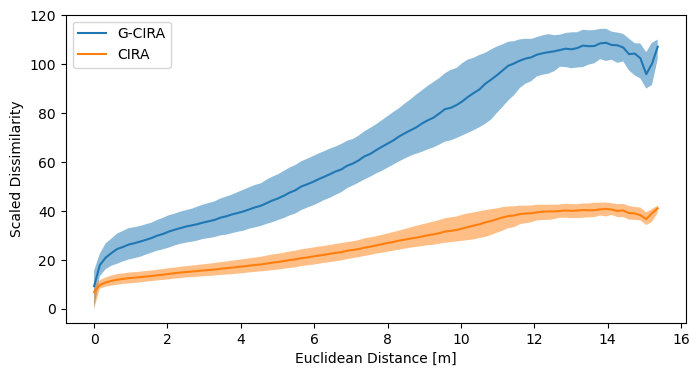

In [9]:
def plot_dissimilarity_over_euclidean_distance(dissimilarity_matrix, distance_matrix, label = None):
    nth_reduction = 10
    dissimilarities_flat = dissimilarity_matrix[::nth_reduction, ::nth_reduction].flatten()
    distances_flat = distance_matrix[::nth_reduction, ::nth_reduction].flatten()
    
    max_distance = np.max(distances_flat)
    bins = np.linspace(0, max_distance, 100)
    bin_indices = np.digitize(distances_flat, bins)
    
    bin_medians = np.zeros(len(bins) - 1)
    bin_25_perc = np.zeros(len(bins) - 1)
    bin_75_perc = np.zeros(len(bins) - 1)
    for i in range(1, len(bins)):
        bin_values = dissimilarities_flat[bin_indices == i]
        bin_25_perc[i - 1], bin_medians[i - 1], bin_75_perc[i - 1] = np.percentile(bin_values, [25, 50, 75])
    
    plt.plot(bins[:-1], bin_medians, label = label)
    plt.fill_between(bins[:-1], bin_25_perc, bin_75_perc, alpha=0.5)
    
plt.figure(figsize=(8,4))

plot_dissimilarity_over_euclidean_distance(dissimilarity_matrix_geodesic, groundtruth_distance_matrix, "G-CIRA")
plot_dissimilarity_over_euclidean_distance(cira_dissimilarity_matrix, groundtruth_distance_matrix, "CIRA")

plt.legend()
plt.xlabel("Euclidean Distance [m]")
plt.ylabel("Scaled Dissimilarity")
plt.show()

# Manifold Learning: Finding the Low-Dimensional Representation

### The First Channel Chart: MDS / Isomap

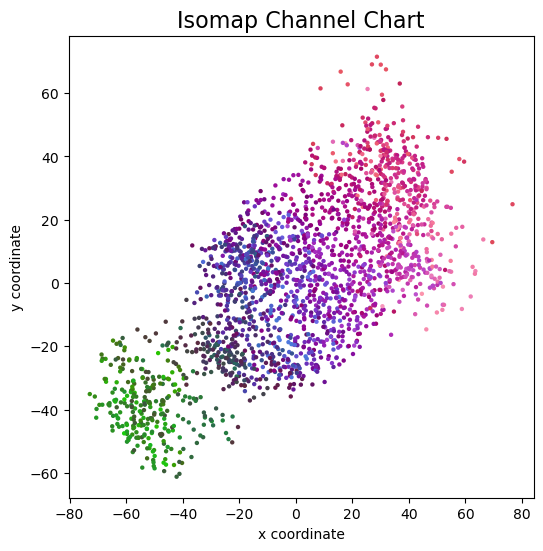

In [10]:
nth_reduction = 10

reduced_dissimilarity_matrix_geodesic = dissimilarity_matrix_geodesic[::nth_reduction, ::nth_reduction]
embedding_isomap = MDS(metric = True, dissimilarity = 'precomputed', max_iter = 80, normalized_stress = False)
proj_isomap = embedding_isomap.fit_transform(reduced_dissimilarity_matrix_geodesic)
plot_colorized(proj_isomap, groundtruth_positions[::nth_reduction], title = "Isomap Channel Chart")

### Feature Engineering

In [11]:
class FeatureEngineeringLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(FeatureEngineeringLayer, self).__init__(dtype = tf.complex64)

    def call(self, csi_tdomain):
        # Remove any remaining sampling time offset *antenna-wise*
        pdp = tf.math.abs(csi_tdomain)
        pdp_logarithmic = tf.math.log(pdp) / tf.math.log(10.0)
        return tf.stack([pdp_logarithmic, tf.math.real(csi_tdomain), tf.math.imag(csi_tdomain)], axis = -1)

### The Forward Charting Function: Defining the Neural Network

In [12]:
array_count = np.shape(csi_time_domain)[1]
antenna_per_array_count = np.shape(csi_time_domain)[2]
tap_count = np.shape(csi_time_domain)[3]

cc_embmodel_input = tf.keras.Input(shape=(array_count, antenna_per_array_count, tap_count), name="input", dtype = tf.complex64)
cc_embmodel_output = FeatureEngineeringLayer()(cc_embmodel_input)
cc_embmodel_output = tf.keras.layers.Flatten()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(1024, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(512, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(256, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(128, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(64, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(2, activation = "linear")(cc_embmodel_output)

cc_embmodel = tf.keras.Model(inputs=cc_embmodel_input, outputs=cc_embmodel_output, name = "ForwardChartingFunction")

### Siamese Neural Network

In [13]:
dissimilarity_margin = np.quantile(dissimilarity_matrix_geodesic, 0.01)

def siamese_loss(y_true, y_pred):
    y_true = y_true[:,0]
    pos_A, pos_B = (y_pred[:,:2], y_pred[:,2:])
    distances_pred = tf.math.reduce_euclidean_norm(pos_A - pos_B, axis = 1)

    return tf.reduce_mean(tf.square(distances_pred - y_true) / (y_true + dissimilarity_margin))

In [14]:
input_A = tf.keras.layers.Input(shape = (array_count, antenna_per_array_count, tap_count,), dtype = tf.complex64)
input_B = tf.keras.layers.Input(shape = (array_count, antenna_per_array_count, tap_count,), dtype = tf.complex64)

embedding_A = cc_embmodel(input_A)
embedding_B = cc_embmodel(input_B)

output = tf.keras.layers.concatenate([embedding_A, embedding_B], axis=1)
model = tf.keras.models.Model([input_A, input_B], output, name = "SiameseNeuralNetwork")

### Sample Selection

In [15]:
csi_time_domain_tensor = tf.constant(csi_time_domain)
dissimilarity_matrix_geodesic_tensor = tf.constant(dissimilarity_matrix_geodesic)

datapoint_count = tf.shape(csi_time_domain_tensor)[0].numpy()

random_integer_pairs_dataset = tf.data.Dataset.zip(tf.data.Dataset.random(), tf.data.Dataset.random())

@tf.function
def fill_pairs(randA, randB):
    return (csi_time_domain_tensor[randA % datapoint_count], csi_time_domain_tensor[randB % datapoint_count]), dissimilarity_matrix_geodesic_tensor[randA % datapoint_count, randB % datapoint_count]

random_pair_dataset = random_integer_pairs_dataset.map(fill_pairs)

2024-04-14 17:14:16.621500: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1739056804 exceeds 10% of free system memory.
2024-04-14 17:14:17.548350: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1739056804 exceeds 10% of free system memory.


### Training


Training Session  1 
Batch Size:  500 
Learning rate:  0.01


2024-04-14 17:14:18.195878: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1739056804 exceeds 10% of free system memory.
2024-04-14 17:14:20.976726: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-14 17:14:21.011686: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa786493cd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-14 17:14:21.011720: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-04-14 17:14:21.015885: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-14 17:14:21.027859: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-04-14 17:14:21.11173

300/300 [==============================] - 6s 8ms/step - loss: 2.8913
Running inference to plot channel chart
652/652 [==============================] - 1s 2ms/step


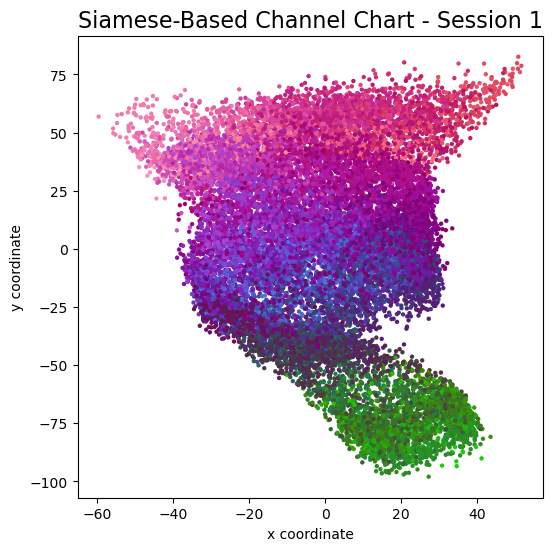


Training Session  2 
Batch Size:  1000 
Learning rate:  0.01


2024-04-14 17:14:26.895689: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1739056804 exceeds 10% of free system memory.


150/150 [==============================] - 2s 16ms/step - loss: 1.2122
Running inference to plot channel chart
652/652 [==============================] - 1s 2ms/step


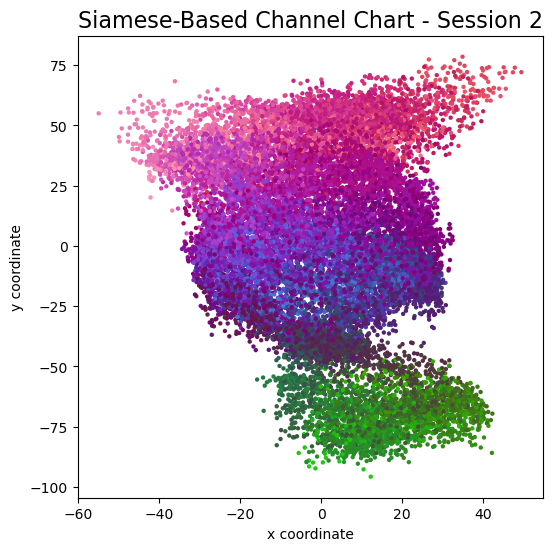


Training Session  3 
Batch Size:  1500 
Learning rate:  0.008
100/100 [==============================] - 2s 24ms/step - loss: 1.1062
Running inference to plot channel chart
652/652 [==============================] - 1s 2ms/step


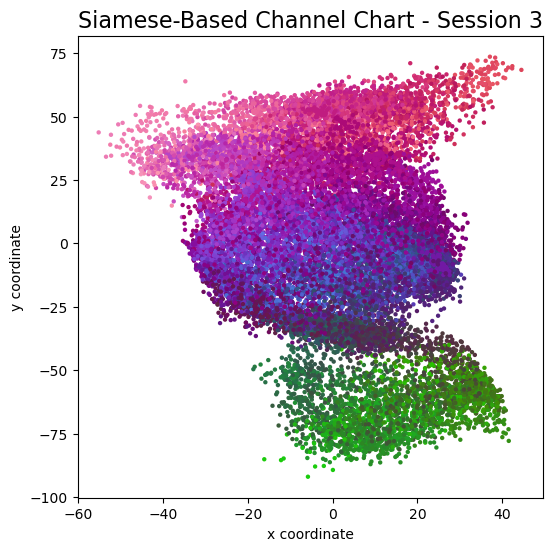


Training Session  4 
Batch Size:  2000 
Learning rate:  0.004
75/75 [==============================] - 2s 32ms/step - loss: 1.0809
Running inference to plot channel chart
652/652 [==============================] - 1s 1ms/step


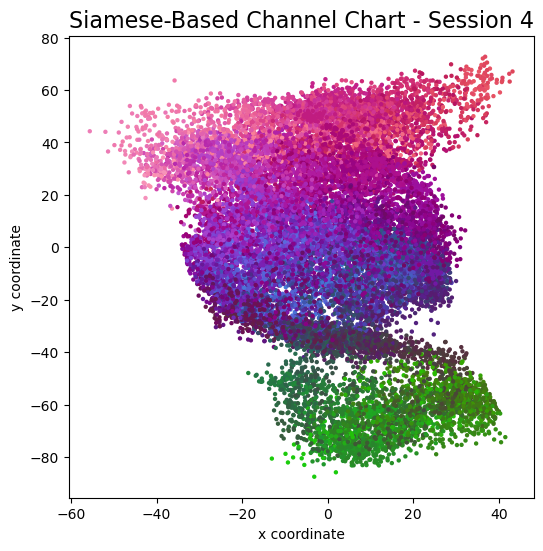


Training Session  5 
Batch Size:  3000 
Learning rate:  0.001
50/50 [==============================] - 2s 45ms/step - loss: 1.0503
Running inference to plot channel chart
652/652 [==============================] - 1s 1ms/step


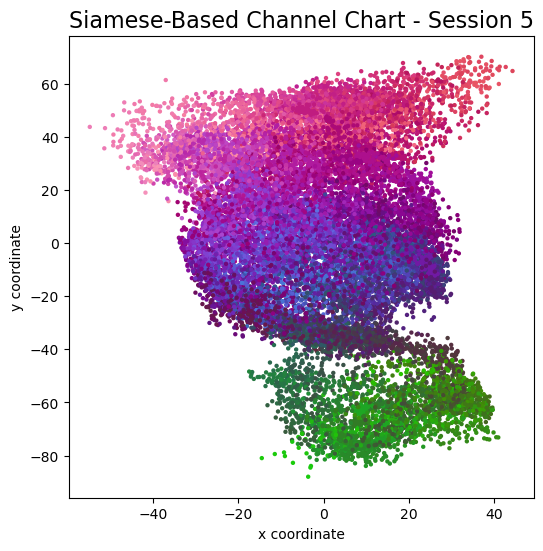


Training Session  6 
Batch Size:  4000 
Learning rate:  0.0005
37/37 [==============================] - 2s 60ms/step - loss: 1.0478
Running inference to plot channel chart
652/652 [==============================] - 1s 2ms/step


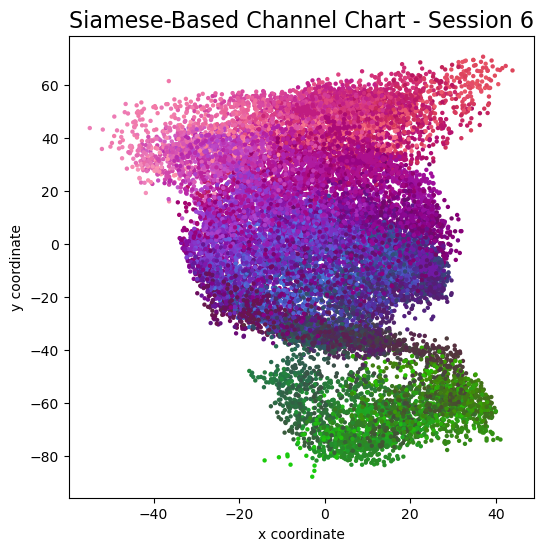


Training Session  7 
Batch Size:  5000 
Learning rate:  0.0002
30/30 [==============================] - 2s 79ms/step - loss: 1.0303
Running inference to plot channel chart
652/652 [==============================] - 1s 1ms/step


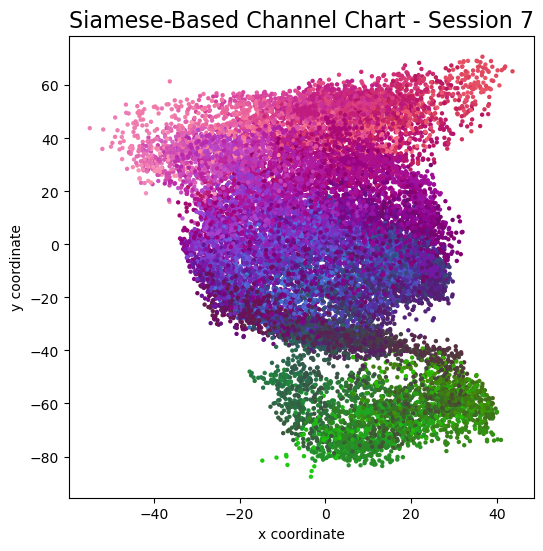


Training Session  8 
Batch Size:  6000 
Learning rate:  0.0001
25/25 [==============================] - 2s 98ms/step - loss: 1.0244
Running inference to plot channel chart
652/652 [==============================] - 1s 1ms/step


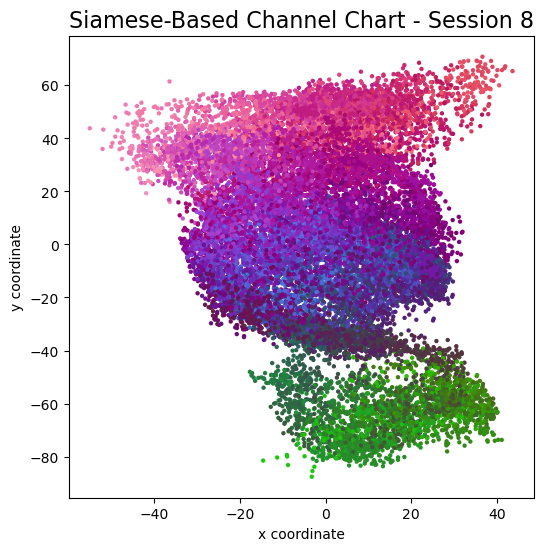

In [16]:
optimizer = tf.keras.optimizers.Adam()
model.compile(loss = siamese_loss, optimizer = optimizer)

samples_per_session = 150000
learning_rates = [1e-2, 1e-2, 8e-3, 4e-3, 1e-3, 5e-4, 2e-4, 1e-4]
batch_size = [500, 1000, 1500, 2000, 3000, 4000, 5000, 6000]

for l in range(len(learning_rates)):
    print("\nTraining Session ", l + 1, "\nBatch Size: ", batch_size[l], "\nLearning rate: ", learning_rates[l])

    # Fit model
    optimizer.learning_rate.assign(learning_rates[l])
    model.fit(random_pair_dataset.batch(batch_size[l]).prefetch(tf.data.AUTOTUNE), steps_per_epoch = samples_per_session // batch_size[l])

    # Plot Channel Chart
    print("Running inference to plot channel chart")
    channel_chart_positions = cc_embmodel.predict(csi_time_domain)
    plot_colorized(channel_chart_positions, groundtruth_positions, title = "Siamese-Based Channel Chart - Session " + str(l + 1))

# Evaluation

Note that we evaluate on the training set here (which is reasonable, since we are evaluating a self-supervised learning technique). But it is just as easy to evaluate on the test set, and you will get very similar results (see paper).

Since the FCF has no information about the globel geometry, we only evaluate the channel chart *after* applying the optimal affine transform. This is an unfair advantage that we grant to the baseline, because we know that we can outperform it anyway.

### Helper Functions

In [17]:
# Continuity is identical to trustworthiness, except that original space and embedding space are swapped
def continuity(*args, **kwargs):
    args = list(args)
    args[0], args[1] = args[1], args[0]
    return trustworthiness(*args, **kwargs)

def kruskal_stress(X, X_embedded):
    dist_X = distance_matrix(X, X)
    dist_X_embedded = distance_matrix(X_embedded, X_embedded)
    beta = np.divide(np.sum(dist_X * dist_X_embedded), np.sum(dist_X_embedded * dist_X_embedded))

    return np.sqrt(np.divide(np.sum(np.square((dist_X - beta * dist_X_embedded))), np.sum(dist_X * dist_X)))

def plot_ecdf(err, label = None):
    count, bins_count = np.histogram(err, bins=200)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    
    bins_count[0] = 0
    cdf = np.append([0], cdf)

    plt.plot(bins_count, cdf, label = label)

def plot_quiver(positions, reference_positions, title = None, nth_errorvector = 15):
    errorvectors = reference_positions[:,:2] - positions
    errors = np.sqrt(errorvectors[:,0]**2 + errorvectors[:,1]**2)
    mae = np.mean(errors)
    
    fulltitle = f"Error Vectors, MAE = {mae:.4f}m"
    if title is not None:
        fulltitle = title + " - " + fulltitle
    plot_colorized(positions, reference_positions, title = fulltitle, show = False, alpha = 0.3)
    plt.quiver(positions[::nth_errorvector, 0], positions[::nth_errorvector, 1], errorvectors[::nth_errorvector, 0], errorvectors[::nth_errorvector, 1], color = "black", angles = "xy", scale_units = "xy", scale = 1)
    plt.show()

652/652 [==============================] - 1s 2ms/step


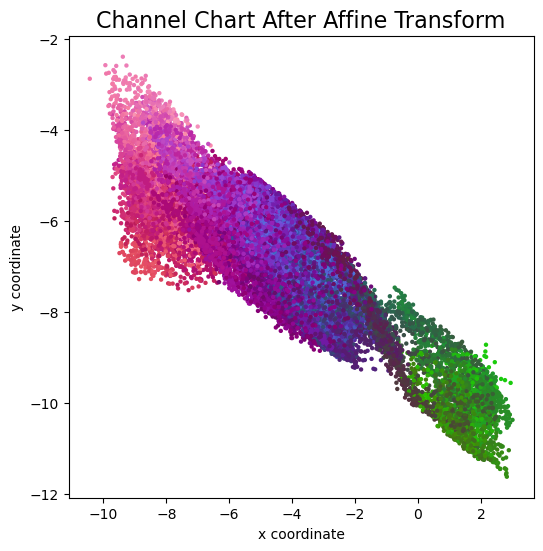

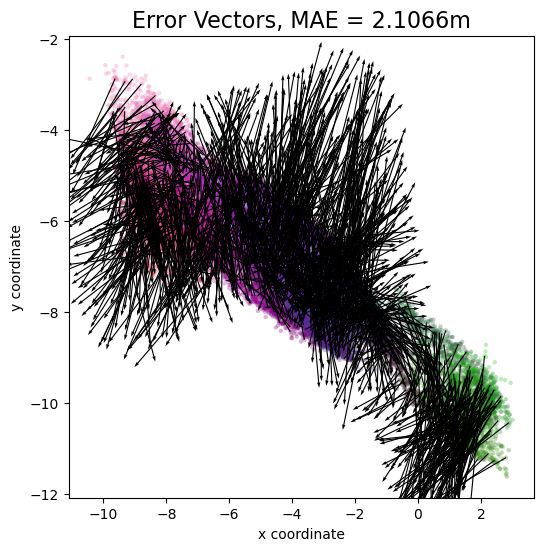

In [18]:
channel_chart_positions = cc_embmodel.predict(csi_time_domain)

def affine_transform_channel_chart(groundtruth_pos, channel_chart_pos):
    pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
    unpad = lambda x: x[:,:-1]
    A, res, rank, s = np.linalg.lstsq(pad(channel_chart_pos), pad(groundtruth_pos), rcond = None)
    transform = lambda x: unpad(np.dot(pad(x), A))
    return transform(channel_chart_pos)

channel_chart_positions_transformed = affine_transform_channel_chart(groundtruth_positions, channel_chart_positions)
plot_colorized(channel_chart_positions_transformed, groundtruth_positions, title = "Channel Chart After Affine Transform")
plot_quiver(channel_chart_positions_transformed[:,:2], groundtruth_positions[:,:2])

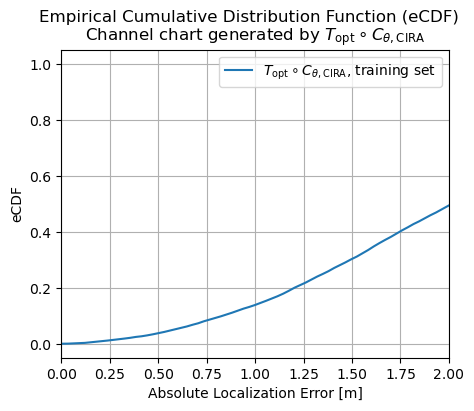

In [19]:
errorvectors_transformed = groundtruth_positions[:,:2] - channel_chart_positions_transformed[:,:2]
errors_transformed = np.sqrt(errorvectors_transformed[:,0]**2 + errorvectors_transformed[:,1]**2)

plt.figure(figsize=(5, 4))
plt.xlim((0, 2))
plt.xlabel("Absolute Localization Error [m]")
plt.ylabel("eCDF")
plt.suptitle("Empirical Cumulative Distribution Function (eCDF)")
plt.title("Channel chart generated by $T_\mathrm{opt} \\circ C_{\\theta, \\mathrm{CIRA}}$")
plt.grid()
plot_ecdf(errors_transformed, label = "$T_\\mathrm{opt} \\circ C_{\\theta, \\mathrm{CIRA}}$, training set")
plt.legend()
plt.show()

In [20]:
# Evaluate CT / TW / KS on a subset of the whole dataset
subset_indices = np.random.choice(range(len(groundtruth_positions)), len(groundtruth_positions) // 5)
groundtruth_positions_subset = groundtruth_positions[subset_indices]
channel_chart_positions_subset = channel_chart_positions[subset_indices]

ct = continuity(groundtruth_positions_subset, channel_chart_positions_subset, n_neighbors = int(0.05 * len(groundtruth_positions_subset)))
tw = trustworthiness(groundtruth_positions_subset, channel_chart_positions_subset, n_neighbors = int(0.05 * len(groundtruth_positions_subset)))
ks = kruskal_stress(groundtruth_positions_subset, channel_chart_positions_subset)

print(f" MAE: {np.mean(errors_transformed):.3f}m")
print(f"DRMS: {np.sqrt(np.mean(np.square(errors_transformed))):.3f}m")
print(f" CEP: {np.median(errors_transformed):.3f}m")
print(f" R95: {np.percentile(errors_transformed, 95):.3f}m")
print(f"  CT: {ct:.4f}")
print(f"  TW: {tw:.4f}")
print(f"  KS: {ks:.4f}")

 MAE: 2.107m
DRMS: 2.349m
 CEP: 2.016m
 R95: 4.112m
  CT: 0.8761
  TW: 0.8703
  KS: 0.2988
